## Cargar paquetes, cargar capas y definir funciones

In [ ]:
!pip install eefolium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 1.0 MB/s eta 0:00:00


In [ ]:
import ee

In [ ]:
import eefolium as geemap

In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize(project='ee-albalinares20')

In [ ]:
zone = ee.FeatureCollection('projects/ee-albalinares20/assets/albufhondaB')
zone2 = ee.FeatureCollection('projects/ee-albalinares20/assets/albufnuevaB')
zone3 = ee.FeatureCollection('projects/ee-albalinares20/assets/barraguaB')
zone4 = ee.FeatureCollection('projects/ee-albalinares20/assets/canoriasB')
zone5 = ee.FeatureCollection('projects/ee-albalinares20/assets/cembalnegB')
zone6 = ee.FeatureCollection('projects/ee-albalinares20/assets/charcpentB')
zone7 = ee.FeatureCollection('projects/ee-albalinares20/assets/humbazaB')
zone8 = ee.FeatureCollection('projects/ee-albalinares20/assets/laggravB')
zone9 = ee.FeatureCollection('projects/ee-albalinares20/assets/ramoraB')
zone10 = ee.FeatureCollection('projects/ee-albalinares20/assets/ribalgaidaB')
zone11 = ee.FeatureCollection('projects/ee-albalinares20/assets/rioantasB')
zone12 = ee.FeatureCollection('projects/ee-albalinares20/assets/salcaboB')
zone13 = ee.FeatureCollection('projects/ee-albalinares20/assets/salcanosB')
zone14 = ee.FeatureCollection('projects/ee-albalinares20/assets/salcerrB')
zone15 = ee.FeatureCollection('projects/ee-albalinares20/assets/salmargenB')

zone99 = ee.FeatureCollection('projects/ee-albalinares20/assets/salcanosC_WGS84')

In [ ]:
#Aquí se va cambiando la zona para el análisis
zone = zone99
zone = ee.FeatureCollection('projects/ee-albalinares20/assets/grupo_1_4326')
#Recordemos que también hay que cambiarlo del código de exportación

In [ ]:
def get_LSWI(img):
  return img.addBands(img.normalizedDifference(["B4","B5"]).rename("LSWI")) #Son las bandas B4 = NIR y B5 = SWIR-1, porque LSWI = (N - S1)/(N + S1)

## Mapas LSWI

In [ ]:
#Carga de la colección de imágenes Landsat 7 con reflectancia superficial filtrados por fecha y zona
l7collection = (
    ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") #SR = surface reflectance de Landsat 7
    .filterBounds(zone) #extensión, lo que encuadra a la capa
    .filterDate("1999-01-01","2021-12-31") #periodo en el que ha estado Landsat 7 recopilando imágenes
)

#CÁLCULO DEL ÍNDICE LSWI (Land Surface Water Index) PARA CADA IMAGEN EN LA COLECCIÓN, crea un mosaico de calidad basado en el LSWI y lo recorta según la zona definida. Posteriormente, calcula el promedio del LSWI para cada año en el rango de años especificado, almacenando las bandas resultantes en una lista llamada bands.

l7lswi = l7collection.map(get_LSWI) #.map es un loop. Para cada objeto de la lista, le aplica iterativamente la función get_LSWI
#clip es lo que lo encuadra dentro de la zona del humedal
#En base a la banda que hemos nombrado LSWI
#.Reducer.mean te escoge el valor medio en base a LSWI
composite = l7lswi.select('LSWI').reduce(ee.Reducer.mean()).rename('LSWI').clip(zone)
band = composite.select("LSWI")

#PARA CALCULAR EL LSWI EN VARIOS AÑOS:
bands = []

years = range(1999,2022) #Porque empieza a contar en 1999 y termina en 2021
for year in years:
  str_year=str(year)
  print(str_year)
  l7collection = (
    ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")
    .filterBounds(zone)
    .filterDate(str_year + "-01-01",str_year + "-12-31")
)

  l7lswi = l7collection.map(get_LSWI)
  composite = l7lswi.select('LSWI').reduce(ee.Reducer.mean()).rename('LSWI').clip(zone)

#SE ALMACENAN LAS BANDAS DE LAS IMÁGENES CON EL CÁLCULO DEL LSWI EN bands
  band = composite.select("LSWI")
  bands.append(band) #band tiene 23 elementos, uno para cada año

1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:204: DeprecationWarning: 

Attention required for LANDSAT/LE07/C01/T1_SR! You are using a deprecated asset.
To ensure continued functionality, please update it by July 1, 2024.
Learn more: https://developers.google.com/earth-engine/landsat_c1_to_c2

  warnings.warn(warning, category=DeprecationWarning)


In [ ]:
vmin = band.reduceRegion(ee.Reducer.min(), zone).get("LSWI").getInfo()
print(vmin)

None


In [ ]:
vmax = band.reduceRegion(ee.Reducer.max(), zone).get("LSWI").getInfo()
print(vmax)

None


In [ ]:
#HACEMOS LOS MAPAS DE LSWI DE LA ZONA DEL BUFFER DEL HUMEDAL CON EL DESPLEGABLE POR AÑO
m = geemap.Map() # Inicializamos un mapa vacío
m.centerObject(zone, zoom=15)
vis_params = {"min": vmin, "max": vmax, "palette":['#a6611a','#dfc27d','#f5f5f5','#80cdc1','#018571']} #Paleta: marrón, blanco y azul turquesa, principalmente
m.addLayer(band,vis_params,"LSWI")

for posicion, banda in enumerate(bands):
  m.addLayer(banda,vis_params,"LSWI_"+str(1999 + posicion))
m.addLayerControl() # Para escoger qué mapas ver con un desplegable para los distintos años

m

## Cálculo y exportación de la gráfica del LSWI medio anual en la zona

In [ ]:
#VALORES LSWI PARA LA ZONA DEL HUMEDAL EN CADA AÑO
data_zone = []
for band in bands:
  data_zone.append(band.reduceRegion(ee.Reducer.mean(), zone, 30).get("LSWI").getInfo())
data_zone

[0.16849043285851276,
 0.16944522695599845,
 0.22118030540122796,
 0.18982205099817476,
 0.32197391071176756,
 0.20509326920798998,
 0.30618978606779684,
 0.15545987931761968,
 0.12303849603045615,
 0.18964962096553808,
 0.2745427372945707,
 0.16442523947401988,
 0.24254725888569287,
 0.18154778644015834,
 0.18613336502433506,
 0.18374288294315366,
 0.18337734900360045,
 0.18851280379349342,
 0.2045070587305856,
 0.24229002428555813,
 0.17074562758132106,
 0.18486824098403126,
 0.20924674686038863]

(0.0, 0.3)

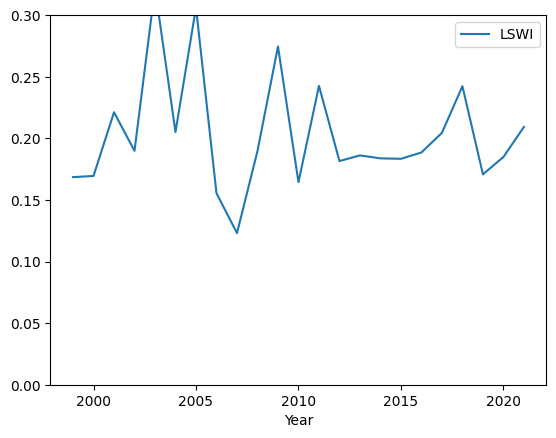

In [ ]:
#GRAFICA PARA VER LOS DATOS
import pandas as pd

df = pd.DataFrame({"LSWI": data_zone}, index=range(1999,2022))
df.index = df.index.rename("Year") #para saber que cada fila corresponde a cada año

graf = df.plot()
graf.set_ylim(0, 0.3)


In [ ]:

# Mostrar el gráfico
#plt.show()

## Mann-Kendall

In [ ]:
#GENERAMOS UNA VARIABLE ÚNICA QUE CONTENGA LAS DIFERENTES CAPAS (bands)
stack_collection = ee.ImageCollection(bands)
lswis = stack_collection.toBands()

In [ ]:
#CALCULAMOS TAU PARA CONOCER LA TENDENCIA DEL HUMEDAL
lswi_trend = lswis.reduce(ee.Reducer.kendallsCorrelation())
tau = lswi_trend.select("tau")

**¿Cómo se pone vmin y vmax al tau?**

In [ ]:
vmin = band.reduceRegion(ee.Reducer.min(), zone).get("Mann-Kendal").getInfo()
print(vmin)

EEException: Dictionary.get: Dictionary does not contain key: Mann-Kendal.

In [ ]:
vmax = band.reduceRegion(ee.Reducer.max(), zone).get("tau").getInfo()
print(vmax)

In [ ]:
#GENERAMOS UN MAPA QUE MUESTRE EL TAU DE CADA PÍXEL DEL BUFFER DEL HUMEDAL
# Los valores negativos indican una tendencia decreciente y los valores positivos indican una tendencia creciente

m = geemap.Map()
m.centerObject(zone, zoom=15)
vis_params = {"min": -1, "max": 1, "palette": ['#d7191c','#fdae61','#ffffbf','#abdda4','#2b83ba']} # Paleta de colores: rojos = negativos, blanco = 0 y azules = positivos.
m.addLayer(tau, vis_params, "Mann-Kendal")
m

##Exportar:

In [ ]:
#EXPORTAMOS EN TIFF
for i, band in enumerate(bands):
  geemap.ee_export_image_to_drive(
      band, "zone1_"+"lswi_"+str(1999+i), folder="GEE_ECOINF", region=zone.geometry(),scale=30
  ) # Nos da 23 mapas raster, uno para cada año
  # .geometry() y no se pone solamente zone, porque region= te pide una propiedad de geometría de un objeto

Exporting zone1_lswi_1999 ...
Exporting zone1_lswi_2000 ...
Exporting zone1_lswi_2001 ...
Exporting zone1_lswi_2002 ...
Exporting zone1_lswi_2003 ...
Exporting zone1_lswi_2004 ...
Exporting zone1_lswi_2005 ...
Exporting zone1_lswi_2006 ...
Exporting zone1_lswi_2007 ...
Exporting zone1_lswi_2008 ...
Exporting zone1_lswi_2009 ...
Exporting zone1_lswi_2010 ...
Exporting zone1_lswi_2011 ...
Exporting zone1_lswi_2012 ...
Exporting zone1_lswi_2013 ...
Exporting zone1_lswi_2014 ...
Exporting zone1_lswi_2015 ...
Exporting zone1_lswi_2016 ...
Exporting zone1_lswi_2017 ...
Exporting zone1_lswi_2018 ...
Exporting zone1_lswi_2019 ...
Exporting zone1_lswi_2020 ...
Exporting zone1_lswi_2021 ...


In [ ]:
#CONECTAR GOOGLE COLAB CON DRIVE
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#EXPORTAR DATOS ANUALES DE LSWI
df.to_csv('/content/drive/My Drive/GEE_ECOINF/lswi_zone.csv')

In [ ]:
#EXPORTAMOS A DRIVE EL MAPA CON LOS VALORES DE TAU
geemap.ee_export_image_to_drive(
    tau, "zone1_"+"tau", folder="GEE_ECOINF",region=zone.geometry(), scale=30
)